### Множественная регрессия

In [1]:
import pandas as pd
import numpy as np

import datetime
from collections import Counter
from itertools import chain
 
import matplotlib.pyplot as plt
import plotly
import seaborn as sns
sns.set()

import statsmodels
import statsmodels.tsa.arima_process
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.api as sma
# from statsmodels.stats.anova import anova_lm
import scipy
from scipy.stats import linregress
import pingouin as pg # реализация стат анализа из R

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
# настройки отображения графиков
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

In [3]:
data_for_model = pd.read_csv('Test_1.csv', sep=';', engine='python', encoding='Windows 1251', decimal= ',')
data_for_model.head()

,City,Date,Регистрации_organic,Переходы_paid,Регистрации_paid,T,RRR,sss,Orders_all,Orders_with_coupon,Num_of_OOH,OTS,Reach,Google Trends,Яндекс Вордстат,TVR
0,Москва,01.01.2018,88,0,16,0.9125,0.0,0.0,17100,0,0,0,0.0,NaN,NaN,0.0
1,Москва,02.01.2018,16,0,0,1.9375,0.0,0.0,11010,0,0,0,0.0,NaN,NaN,0.0
2,Москва,03.01.2018,8,0,0,2.3875,0.6,0.0,11040,0,0,0,0.0,NaN,NaN,0.0
3,Москва,04.01.2018,0,0,8,2.0375,0.0,0.0,11190,0,0,0,0.0,NaN,NaN,0.0
4,Москва,07.01.2018,0,0,0,1.8250,1.3,0.0,13260,0,0,0,0.0,NaN,NaN,0.0


In [4]:
data_for_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5762 entries, 0 to 5761
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   City                 5762 non-null   object 
 1   Date                 5762 non-null   object 
 2   Регистрации_organic  5762 non-null   int64  
 3   Переходы_paid        5762 non-null   int64  
 4   Регистрации_paid     5762 non-null   int64  
 5   T                    5762 non-null   float64
 6   RRR                  5762 non-null   float64
 7   sss                  5762 non-null   float64
 8   Orders_all           5762 non-null   int64  
 9   Orders_with_coupon   5762 non-null   int64  
 10  Num_of_OOH           5762 non-null   int64  
 11  OTS                  5762 non-null   int64  
 12  Reach                5762 non-null   float64
 13  Google Trends        5571 non-null   float64
 14  Яндекс Вордстат      4991 non-null   float64
 15  TVR                  5762 non-null   f

In [5]:
# Переименование столбцов
data_for_model = data_for_model.rename(columns=lambda x: x.replace(' ', '_'))

In [6]:
# Список долей отсутствующих записей для каждого признака
for col in data_for_model.columns:
    pct_missing = np.mean(data_for_model[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing * 100)))

City - 0%
Date - 0%
Регистрации_organic - 0%
Переходы_paid - 0%
Регистрации_paid - 0%
T - 0%
RRR - 0%
sss - 0%
Orders_all - 0%
Orders_with_coupon - 0%
Num_of_OOH - 0%
OTS - 0%
Reach - 0%
Google_Trends_ - 3%
Яндекс_Вордстат - 13%
TVR - 0%


In [7]:
# Для включения в модель исследования фактора City, не имеющего количественного измерения, 
# городам будет присвоем номер количества их повторений в выборке если количество повторений уникально

city_count = data_for_model['City']
city = Counter(city_count)
city

Counter({'Москва': 861,
         'Ярославль': 587,
         'Самара': 427,
         'Нижний Новгород': 326,
         'Казань': 312,
         'Санкт-Петербург': 291,
         'Новосибирск': 285,
         'Саратов': 276,
         'Пермь': 270,
         'Ульяновск': 263,
         'Омск': 254,
         'Краснодар': 249,
         'Екатеринбург': 235,
         'Челябинск': 228,
         'Красноярск': 221,
         'Уфа': 214,
         'Воронеж': 158,
         'Ростов-на-Дону': 144,
         'Волгоград': 130,
         'Тюмень': 31})

In [8]:
# Количество повторений городов (поиск повторяющихся значений из словаря с помощью набора)
rev_dict = {}

for key, value in city.items():
    rev_dict.setdefault(value, set()).add(key)


result = set(chain.from_iterable(
         values for key, values in rev_dict.items()
         if len(values) > 1))

print("Список значний атибута City с одинаковой частотой повторений", str(result))

Список значний атибута City с одинаковой частотой повторений set()


In [9]:
# Количественная определенность для качественного фактора
data_for_model['city_number'] = data_for_model['City']
data_for_model['city_number'] = data_for_model.groupby(['City']).transform(np.size)

In [10]:
# Замена отсутствующих значений в столбце
data_for_model['Google_Trends_'] = data_for_model['Google_Trends_'].fillna(0)
data_for_model['Яндекс_Вордстат'] = data_for_model['Яндекс_Вордстат'].fillna(0)

In [11]:
# Временной диапазон исследования
data_for_model['Date']= pd.to_datetime(data_for_model['Date'])
print(data_for_model['Date'].max())
print(data_for_model['Date'].min())

2020-12-06 00:00:00
2018-01-01 00:00:00


### А) сколько платежей в каждом городе принесла ТВ-кампания 

(с обоснованием валидности расчетов и оценкой качества модели)

#### Отбор факторов и выбор уравнения регрессии

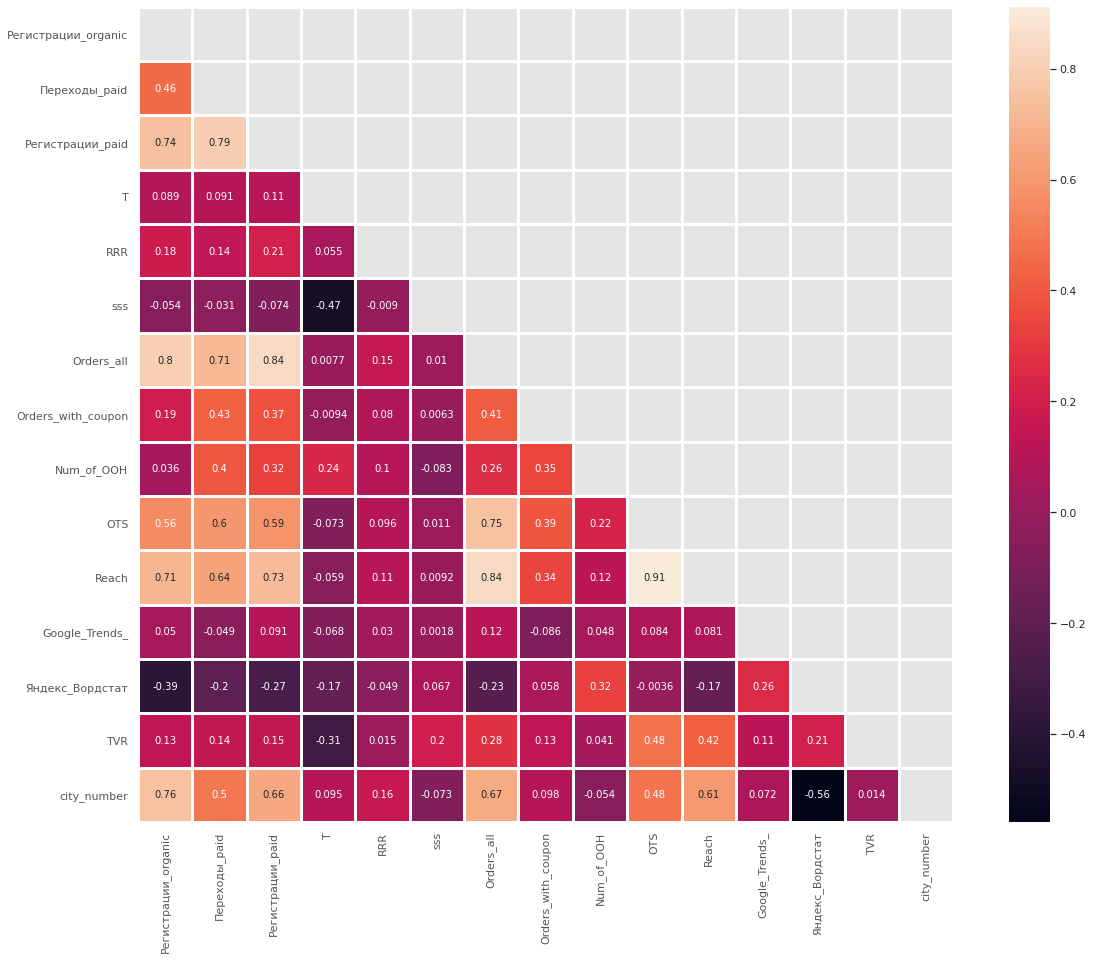

In [12]:
# матрица корреляции 
fig, ax = plt.subplots(figsize=(20, 15))
corr = data_for_model.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('dark'):
    ax = sns.heatmap(corr,
                     mask=mask,
                     square=True,
                     cbar=True,
                     annot=True,
                     linewidths=3)

In [13]:
data_for_model = data_for_model.drop(['OTS', 'T', 'Яндекс_Вордстат','sss','Date', 'City'], axis=1)

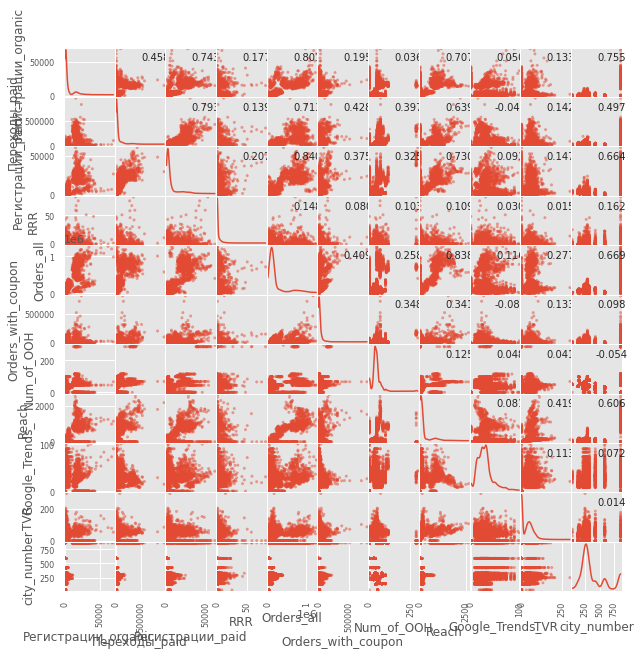

In [14]:
axes = pd.plotting.scatter_matrix(data_for_model, figsize=(10,10), diagonal='kde', grid=True)
corr = data_for_model.corr().values
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')

<AxesSubplot:xlabel='Reach', ylabel='Orders_all'>

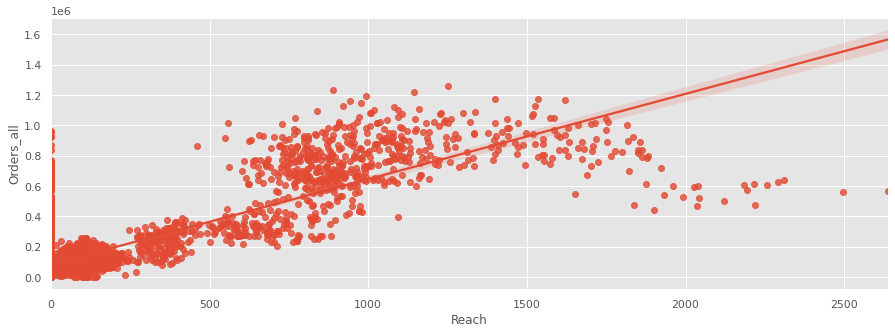

In [15]:
# линейная зависимость между 
sns.regplot(x="Reach", y="Orders_all", data=data_for_model)

In [16]:
y = data_for_model['Orders_all'] # зависимая переменная
x = data_for_model.drop(['Orders_all'], axis=1) #независимые переменные

In [17]:
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=0)

In [18]:

# Обучение модели
model = LinearRegression()
model.fit(X_train,y_train)
# Прогнозирования целевых значений тестовых данных
y_pred = model.predict(X_test)

# Точность модели
model.score(X_test,y_test)

0.854514635096786

In [19]:
x.columns.tolist()

['Регистрации_organic',
 'Переходы_paid',
 'Регистрации_paid',
 'RRR',
 'Orders_with_coupon',
 'Num_of_OOH',
 'Reach',
 'Google_Trends_',
 'TVR',
 'city_number']

In [20]:
result = ols(formula="Orders_all ~ Регистрации_organic + Переходы_paid + Регистрации_paid + RRR + Orders_with_coupon +\
             Num_of_OOH + Reach + Google_Trends_ + TVR + city_number", data=data_for_model).fit()

result.params

Intercept             -22432.225993
Регистрации_organic       11.625056
Переходы_paid              0.524786
Регистрации_paid           3.450727
RRR                    -1067.888391
Orders_with_coupon         0.556030
Num_of_OOH               520.676599
Reach                    198.212793
Google_Trends_          1036.537243
TVR                      252.591319
city_number               32.857091
dtype: float64

In [21]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Orders_all   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     3695.
Date:                Mon, 14 Jun 2021   Prob (F-statistic):               0.00
Time:                        21:01:47   Log-Likelihood:                -73362.
No. Observations:                5762   AIC:                         1.467e+05
Df Residuals:                    5751   BIC:                         1.468e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -2.243e+04   4105.403     -5.464      0.000   -3.05e+04   -1.44e+04
Регистрации_organic    11.6251      0.311     37.377      0.000      11.015      12.235
Переходы_paid           0.5248      0.028     18.448      0.000       0.469       0.581
Регистрации_paid        3.4507      0.316     10.931      0.000       2.832       4.070
RRR                 -1067.8884    244.707     -4.364      0.000   -1547.605    -588.171
Orders_with_coupon      0.5560      0.034     16.141      0.000       0.488       0.624
Num_of_OOH            520.6766     48.032     10.840      0.000     426.516     614.837
Reach                 198.2128      6.262     31.651      0.000     185.936     210.489
Google_Trends_       1036.5372     76.004     13.638      0.000     887.541    1185.533
TVR                   252.5913     38.684      6.530      0.000     176.756     328.427
city_number            32.8571      8.110      4.051      0.000      16.958      48.756
==============================================================================
Omnibus:                     1269.163   Durbin-Watson:                   1.495
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23272.416
Skew:                          -0.567   Prob(JB):                         0.00
Kurtosis:                      12.780   Cond. No.                     3.42e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.42e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:>

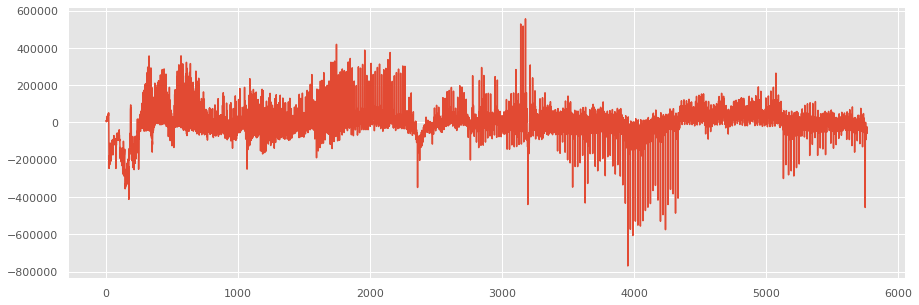

In [25]:
# Распределение остатков. Проблема гетероскедаситчности (непостоянная изменчивость)
result.resid.plot()

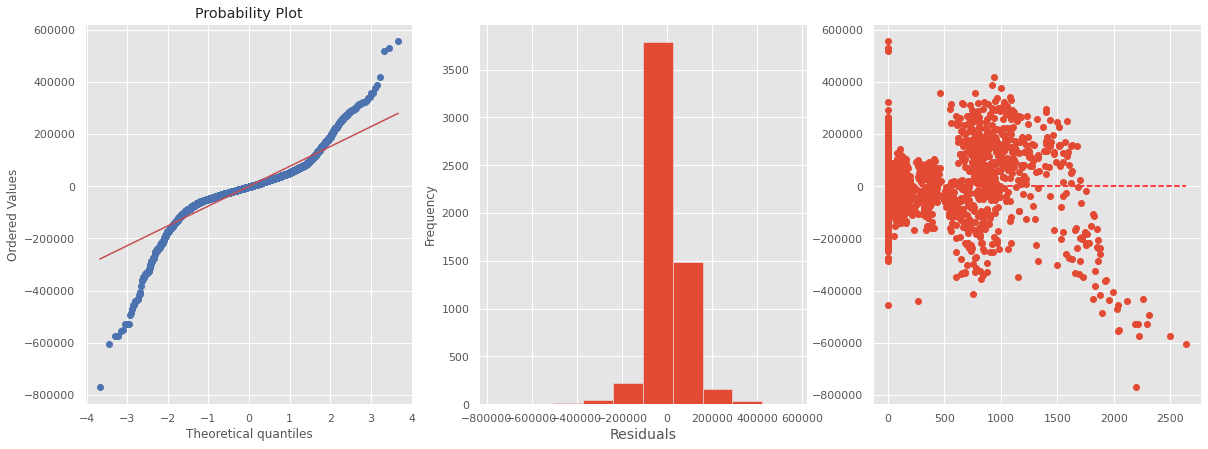

In [23]:

m1 = ols("Orders_all ~ Регистрации_organic + Переходы_paid + Регистрации_paid + RRR + Orders_with_coupon +\
             Num_of_OOH + Reach + Google_Trends_ + TVR + city_number", data=data_for_model)
fitted = m1.fit()

plt.figure(figsize=(20,7))
plt.subplot(131)
scipy.stats.probplot(fitted.resid, dist="norm", plot=plt)
plt.subplot(132)
(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
plt.subplot(133)
plt.plot(data_for_model['Reach'], fitted.resid, 'o')
plt.hlines(np.mean(fitted.resid), data_for_model['Reach'].min(), data_for_model['Reach'].max(), linestyle='--', colors='red');

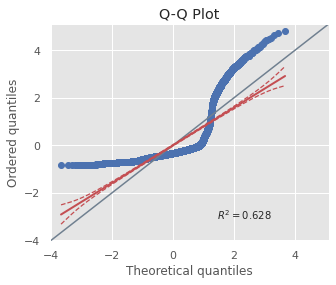

In [24]:
# функция также строит линию наилучшего соответствия (линейная регрессия) для данных и 
# аннотирует график с коэффициентом детерминации

ax = pg.qqplot (data_for_model.Orders_all, dist = 'norm')